# Spatial-Temporal Experiment

In this notebook, I will be walking through how we can estimate different methods based on the density cubes that we derive.

In [1]:
import sys, os
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

import pathlib

# standard python packages
import xarray as xr
import pandas as pd
import numpy as np

# 
# Experiment Functions
from src.data.esdc import get_dataset
from src.features import Metrics
from sklearn.preprocessing import StandardScaler
from src.models.density import get_rbig_model
from src.features.temporal import select_period, get_smoke_test_time, TimePeriod
from src.features.spatial import select_region, get_europe, get_spain
from src.models.train_models import get_similarity_scores
from src.experiments.utils import dict_product, run_parallel_step

from src.features import Metrics
from src.features.density import get_density_cubes
from src.features.preprocessing import standardizer_data, get_reference_cube, get_common_indices
from src.models.similarity import cka_coefficient, rv_coefficient, rbig_it_measures

# # esdc tools
# from src.esdc.subset import select_pixel
# from src.esdc.shape import ShapeFileExtract, rasterize
# from esdc.transform import DensityCubes

from typing import List, Dict
import xarray as xr

from tqdm import tqdm
import time

import cartopy
import cartopy.crs as ccrs

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s: %(levelname)s: %(message)s'
)
logger = logging.getLogger()
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

## Results

In [38]:
!ls /media/disk/erc/papers/2020_rbig_eo/results/spa_temp/information/world/resample
# !mkdir /media/disk/erc/papers/2020_rbig_eo/results/spa_temp/information/world/resample
# !mkdir /media/disk/erc/papers/2020_rbig_eo/results/spa_temp/information/world
# !rm -rf /media/disk/erc/papers/2020_rbig_eo/results/spa_temp/information/world/*

gpp_2002_2010_s200000_d111_v1.csv  lst_2002_2010_s200000_d441_v1.csv
gpp_2002_2010_s200000_d224_v1.csv  precip_2002_2010_s200000_d111_v1.csv
gpp_2002_2010_s200000_d441_v1.csv  precip_2002_2010_s200000_d224_v1.csv
lai_2002_2010_s200000_d111_v1.csv  precip_2002_2010_s200000_d441_v1.csv
lai_2002_2010_s200000_d224_v1.csv  rm_2002_2010_s200000_d111_v1.csv
lai_2002_2010_s200000_d441_v1.csv  rm_2002_2010_s200000_d224_v1.csv
lst_2002_2010_s200000_d111_v1.csv  rm_2002_2010_s200000_d441_v1.csv
lst_2002_2010_s200000_d224_v1.csv


In [17]:
RES_PATH = pathlib.Path(str(root)).joinpath("data/spa_temp/info_earth/world")
SAVE_PATH = pathlib.Path("/media/disk/erc/papers/2020_rbig_eo/results/spa_temp/information/world")
FIG_PATH = pathlib.Path(str(root)).joinpath("reports/figures/spa_temp/demos/infoearth/spain")

In [18]:
!ls $RES_PATH/prob_cubes

v1_north_gpp_2002_2010_s200000_d1112.h5
v1_north_gpp_2002_2010_s200000_d111.h5
v1_north_gpp_2002_2010_s200000_d224.h5
v1_north_gpp_2002_2010_s200000_d441.h5
v1_north_gpp_2002_2010_s200000_d556.h5
v1_north_gpp_2002_2010_s200000_d771.h5
v1_north_lai_2002_2010_s200000_d1112.h5
v1_north_lai_2002_2010_s200000_d111.h5
v1_north_lai_2002_2010_s200000_d224.h5
v1_north_lai_2002_2010_s200000_d441.h5
v1_north_lst_2002_2010_s200000_d1112.h5
v1_north_lst_2002_2010_s200000_d111.h5
v1_north_lst_2002_2010_s200000_d224.h5
v1_north_lst_2002_2010_s200000_d441.h5
v1_north_lst_2002_2010_s200000_d771.h5
v1_north_precip_2002_2010_s200000_d1112.h5
v1_north_precip_2002_2010_s200000_d111.h5
v1_north_precip_2002_2010_s200000_d224.h5
v1_north_precip_2002_2010_s200000_d441.h5
v1_north_rm_2002_2010_s200000_d1112.h5
v1_north_rm_2002_2010_s200000_d111.h5
v1_north_rm_2002_2010_s200000_d224.h5
v1_north_rm_2002_2010_s200000_d441.h5
v1_north_rm_2002_2010_s200000_d771.h5
v1_south_gpp_2002_2010_s200000_d1112.h5
v1_south_gpp

In [28]:
variables = ['rm', 'precip', 'gpp', 'lst', 'lai']

variable = 'gpp'
version = 'v1'
period = '2002_2010'
dimensions = '1146'
samples = '200000'
save_name = f"{variable}_{period}_s{samples}_d{dimensions}_{version}"

def load_world_cubes_rs(
    variable: str='gpp', 
    period: str='2002_2010', 
    samples: str='200000',
    dimensions: str='111',
    version: str='v1',
    split: bool=True,
):
    if split:
        filename_north = f"{version}_north_{variable}_{period}_s{samples}_d{dimensions}"
        filename_south = f"{version}_south_{variable}_{period}_s{samples}_d{dimensions}"

        prob_cubes_n = xr.open_dataset(RES_PATH.joinpath(f"prob_cubes/{filename_north}.h5"))
        prob_cubes_s = xr.open_dataset(RES_PATH.joinpath(f"prob_cubes/{filename_south}.h5"))
        prob_cubes = xr.merge([prob_cubes_n, prob_cubes_s])
    else:
        filename = f"{version}_world_{variable}_{period}_s{samples}_d{dimensions}"
        prob_cubes = xr.open_dataset(RES_PATH.joinpath(f"prob_cubes/{filename}.h5"))
        
    return prob_cubes

In [29]:
variables = ['gpp', 'rm', 'lai', 'lst', 'precip']
dimensions = ['111', '224', '441']
version = 'v1'
period = '2002_2010'
samples = '200000'

for ivariable in variables:
    for idim in dimensions:
        t = load_world_cubes_rs(variable=ivariable, period=period, samples=samples, version=version, dimensions=idim)
        save_name = f"{ivariable}_{period}_s{samples}_d{idim}_{version}"
        t.to_dataframe().dropna().to_csv(SAVE_PATH.joinpath(f"{save_name}.csv"))


In [169]:
prob_cubes = xr.open_dataset(RES_PATH.joinpath(f"prob_cubes/v1_north_gpp_2002_2010_s200000_d111.h5"))
prob_cubes_s = xr.open_dataset(RES_PATH.joinpath(f"prob_cubes/v1_south_gpp_2002_2010_s200000_d111.h5"))
prob_cubes = xr.merge([prob_cubes_n, prob_cubes_s])
prob_cubes

<xarray.Dataset>
Dimensions:       (lat: 543, lon: 1413)
Coordinates:
  * lat           (lat) float64 -55.62 -55.38 -55.12 ... 79.38 79.62 79.88
  * lon           (lon) float64 -179.9 -179.6 -179.4 ... 179.1 179.4 179.6
Data variables:
    probability   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    shannon_info  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [172]:
prob_cubes.to_dataframe().dropna().head()

probability  shannon_info
lat     lon                               
-55.625 -68.125     0.282271      1.264888
        -67.375     0.269545      1.311018
-55.375 -69.625     0.333137      1.099202
        -69.375     0.317363      1.147708
        -69.125     0.293083      1.227299

### Experiment I - Spain, 2010, Cube 1x1x1

For this first experiment, I did something very simple and looked at the density of ESDC as samples. 

In [141]:
variables = ['rm', 'precip', 'gpp', 'lst', 'lai']

variable = 'gpp'
version = 'v1'
period = '2002_2010'
dimensions = '1146'
samples = '200000'
save_name = f"{variable}_{period}_s{samples}_d{dimensions}_{version}"

def load_world_data(
    variable: str='gpp', 
    period: str='2002_2010', 
    samples: str='200000',
    dimensions: str='1146',
    version: str='v1',
    split: bool=True,
):
    if split:
        filename_north = f"{version}_north_{variable}_{period}_s{samples}_d{dimensions}"
        filename_south = f"{version}_south_{variable}_{period}_s{samples}_d{dimensions}"

        probs_df = pd.read_csv(str(RES_PATH.joinpath(f'probs/{filename_north}'+".csv")))
        try:
            probs_df2 = pd.read_csv(str(RES_PATH.joinpath(f'probs/{filename_south}'+".csv")))
            probs_df = pd.concat([probs_df,probs_df2])
        except:
            pass
    else:
        filename = f"{version}_world_{variable}_{period}_s{samples}_d{dimensions}"
        probs_df = pd.read_csv(str(RES_PATH.joinpath(f'probs/{filename}'+".csv")))
        
    return probs_df

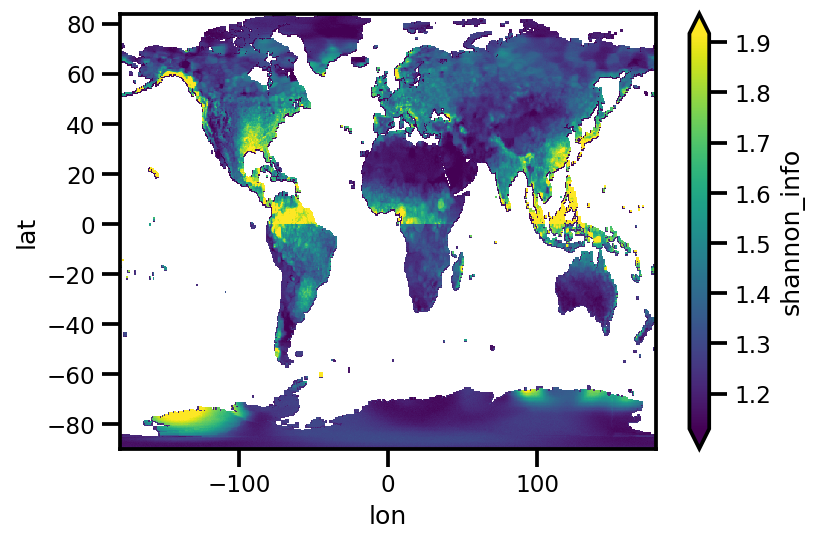

In [36]:
t = pd.read_csv("/media/disk/erc/papers/2020_rbig_eo/results/spa_temp/information/world/precip_2002_2010_s200000_d111_v1.csv")
t.set_index(['lat', 'lon']).to_xarray().shannon_info.plot(robust=True)

In [142]:
probs_df = load_world_data()

In [ ]:
def convert_df_2_xr(df: pd.Dataframe) -> xr.Dataset:
    return None

In [134]:
# region = "north"
period = "2002_2010"
samples = "200000"
dimensions = "1146"
variable = 'precip'
version = 'v1'
filename_north = f"{version}_north_{variable}_{period}_s{samples}_d{dimensions}"
filename_south = f"{version}_south_{variable}_{period}_s{samples}_d{dimensions}"
save_name = f"{variable}_{period}_s{samples}_d{dimensions}_{version}"
# read csv file
probs_df = pd.read_csv(str(RES_PATH.joinpath(f'probs/{filename_north}'+".csv")))
print(probs_df.shape)
try:
    probs_df2 = pd.read_csv(str(RES_PATH.joinpath(f'probs/{filename_south}'+".csv")))
    probs_df = pd.concat([probs_df,probs_df2])
except:
    pass
print(probs_df.shape)
# convert to datetime
# probs_df['time'] = pd.to_datetime(probs_df['time'])
probs_df.to_csv(SAVE_PATH.joinpath(f"{save_name}.csv"))

# create dataframe in the format for xarray
probs_df = probs_df.set_index(['lat', 'lon']).rename(columns={"0": 'probs'})

# remove probabilities greater than 1
# probs_df['probs'][probs_df['probs'] >= 1.0] = np.nan

# shannon info
probs_df['shannon_info'] = - np.log(probs_df['probs'])

# create xarray cubes
probs_cubes = xr.Dataset.from_dataframe(probs_df)
probs_cubes

(202725, 3)
(202725, 3)


<xarray.Dataset>
Dimensions:       (lat: 334, lon: 1436)
Coordinates:
  * lat           (lat) float64 0.375 0.625 0.875 1.125 ... 83.12 83.38 83.62
  * lon           (lon) float64 -179.9 -179.6 -179.4 ... 179.1 179.4 179.6
Data variables:
    probs         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    shannon_info  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [147]:
from typing import Optional
def plot_map(xr_data, measure: str, save_name: Optional[str]=None):
    fig, ax = plt.subplots()
    
    if measure == 'probs':
        xr_data.probability.plot(
            ax=ax,
            vmin=0, robust=True, cmap='Reds', 
            cbar_kwargs={'label': "Probability"}
        )
    elif measure == 'info':
        xr_data.shannon_info.plot(
            ax=ax,
            vmin=0, robust=True, cmap='Reds', 
            cbar_kwargs={'label': "Shannon Information"}
        )
    else:
        raise ValueError(f"Unrecognized measure: {measure}")

    ax.set(
        xlabel='Longitude',
        ylabel='Latitude'
    )
    plt.tight_layout()
    if save_name:
        fig.savefig(FIG_PATH.joinpath(f"{measure}_{save_name}.png"))
    


### Figure I - Probability Maps

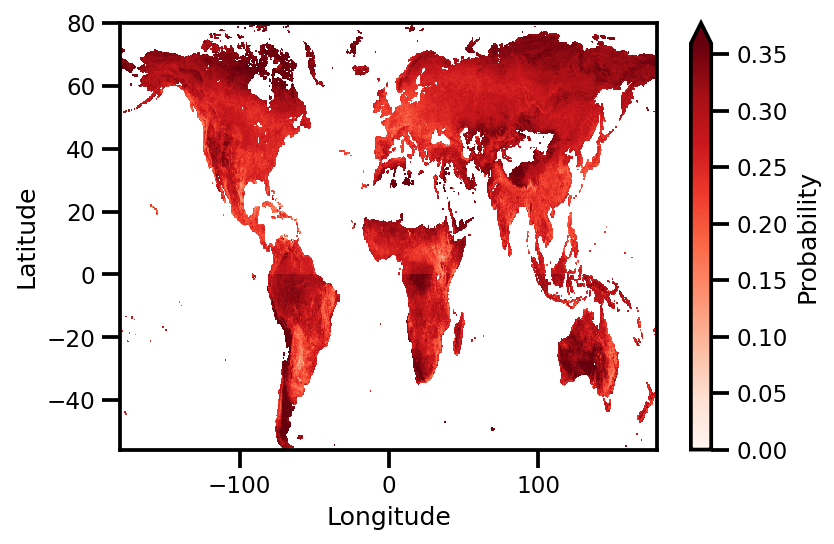

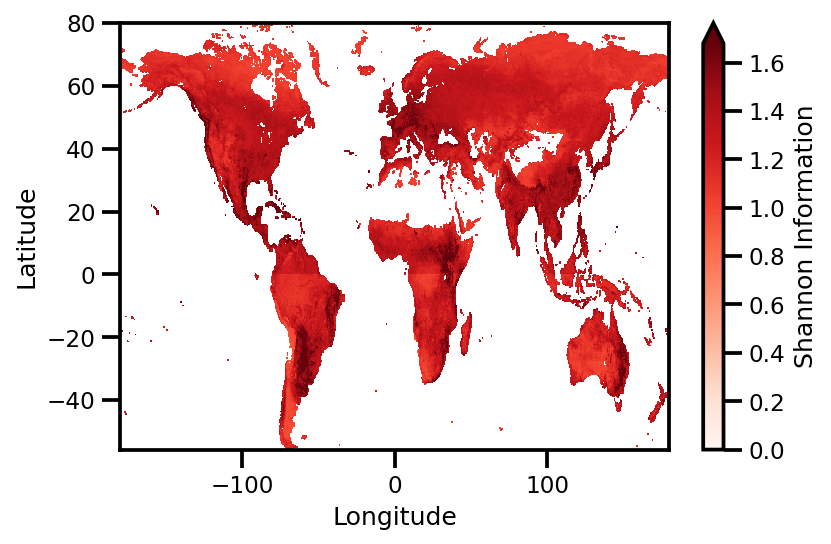

In [170]:
plot_map(prob_cubes, 'probs',  None)
plot_map(prob_cubes, 'info',  None)

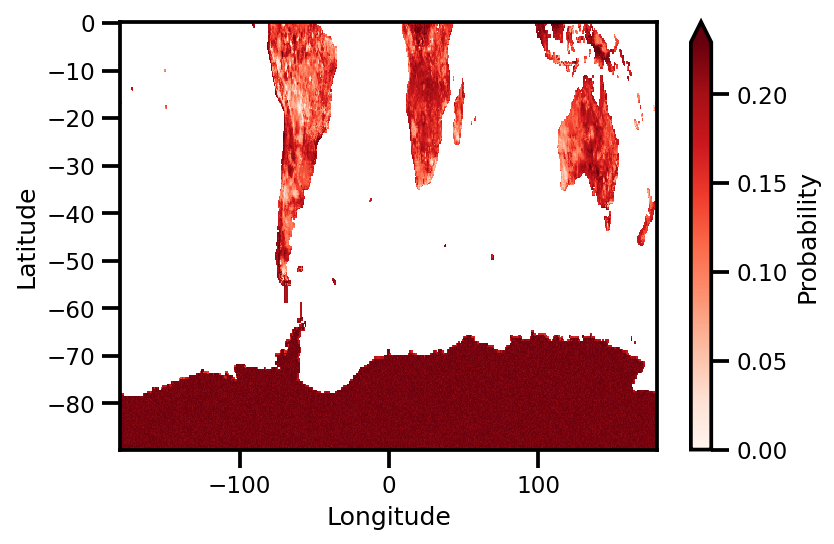

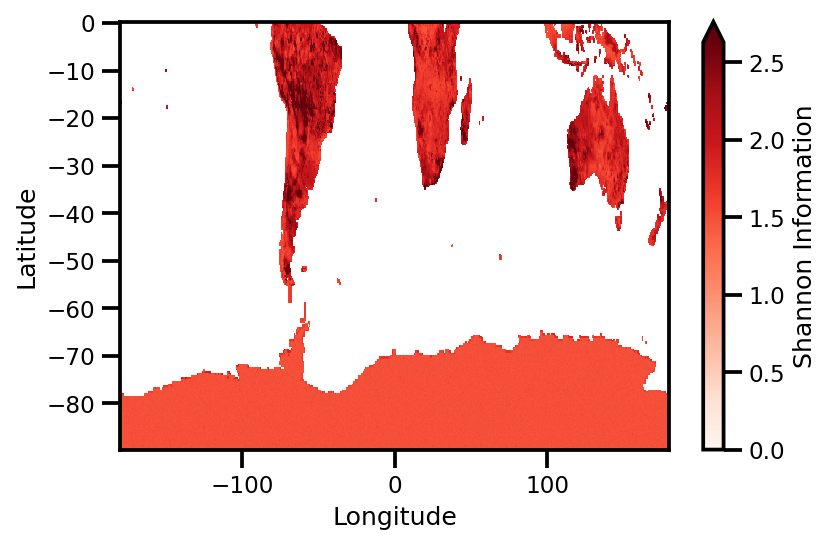

In [51]:
plot_map(probs_cubes, 'probs',  None)
plot_map(probs_cubes, 'info',  None)

### Figure II - Probability Maps, Per Month

In [ ]:
from typing import Optional
def plot_map(xr_data, measure: str, save_name: Optional[str]=None):
    fig, ax = plt.subplots()
    
    if measure == 'probs':
        xr_data.probs.mean(dim='time').plot(
            ax=ax,
            vmin=0, robust=True, cmap='Reds', 
            cbar_kwargs={'label': "Probability"}
        )
    elif measure == 'info':
        xr_data.shannon_info.mean(dim='time').plot(
            ax=ax,
            vmin=0, robust=True, cmap='Reds', 
            cbar_kwargs={'label': "Shannon Information"}
        )
    else:
        raise ValueError(f"Unrecognized measure: {measure}")

    ax.set(
        xlabel='Longitude',
        ylabel='Latitude'
    )
    plt.tight_layout()
    if save_name:
        fig.savefig(FIG_PATH.joinpath(f"{measure}_{save_name}.png"))
    
    
def plot_ts(xr_data, measure: str, save_name: Optional[str]=None):
    fig, ax = plt.subplots()
    
    if measure == 'probs':
        xr_data.probs.mean(dim=['lon', 'lat']).plot.line(ax=ax, color='black', linewidth=3)
        ylabel = 'Probability'
    elif measure == 'info':
        xr_data.shannon_info.mean(dim=['lon', 'lat']).plot.line(ax=ax, color='black', linewidth=3)
        ylabel = 'Shannon Information'
    else:
        raise ValueError(f"Unrecognized measure: {measure}")

    ax.set(
        xlabel='Time',
        ylabel=ylabel
    )

    ax.legend(['Mean Predictions'])
    plt.tight_layout()
    if save_name:
        fig.savefig(FIG_PATH.joinpath(f"{measure}_ts_{save_name}.png"))
        
def plot_ts_error(xr_data, measure: str, save_name: Optional[str]=None):
    
    if measure == 'probs':
        predictions = xr_data.probs.mean(dim=['lat','lon'])
        std = xr_data.probs.std(dim=['lat','lon'])
        ylabel = 'Probabilities'
    elif measure == 'info':
        predictions = xr_data.shannon_info.mean(dim=['lat','lon'])
        std = xr_data.shannon_info.std(dim=['lat','lon'])
        ylabel = 'Shannon Information'
    else:
        raise ValueError(f"Unrecognized measure: {measure}")


    fig, ax = plt.subplots()
    ax.plot(xr_data.coords['time'].values, predictions)
    ax.fill_between(
        predictions.coords['time'].values,
        predictions - std,
        predictions + std,
        alpha=0.7, color='orange'
    )
    ax.set(
        xlabel='Time',
        ylabel=ylabel,
    )
    ax.legend(['Mean_predictions'])
    plt.tight_layout()
    if save_name:
        fig.savefig(FIG_PATH.joinpath(f"{measure}_ts_err_{save_name}.png"))
        
def plot_monthly_map(xr_data, measure: str, save_name: Optional[str]=None):
    plt.figure()
    
    if measure == 'probs':
        xr_data.probs.groupby('time.month').mean().plot.pcolormesh(x='lon', y='lat', col='month', col_wrap=3, vmin=0, robust=True, cmap='Reds')
    elif measure == 'info':
        xr_data.shannon_info.groupby('time.month').mean().plot.pcolormesh(x='lon', y='lat', col='month', col_wrap=3, vmin=0, robust=True, cmap='Reds')
    else:
        raise ValueError(f"Unrecognized measure: {measure}")
        
    plt.savefig(FIG_PATH.joinpath(f"monthly_{save_name}.png"))

<Figure size 432x288 with 0 Axes>

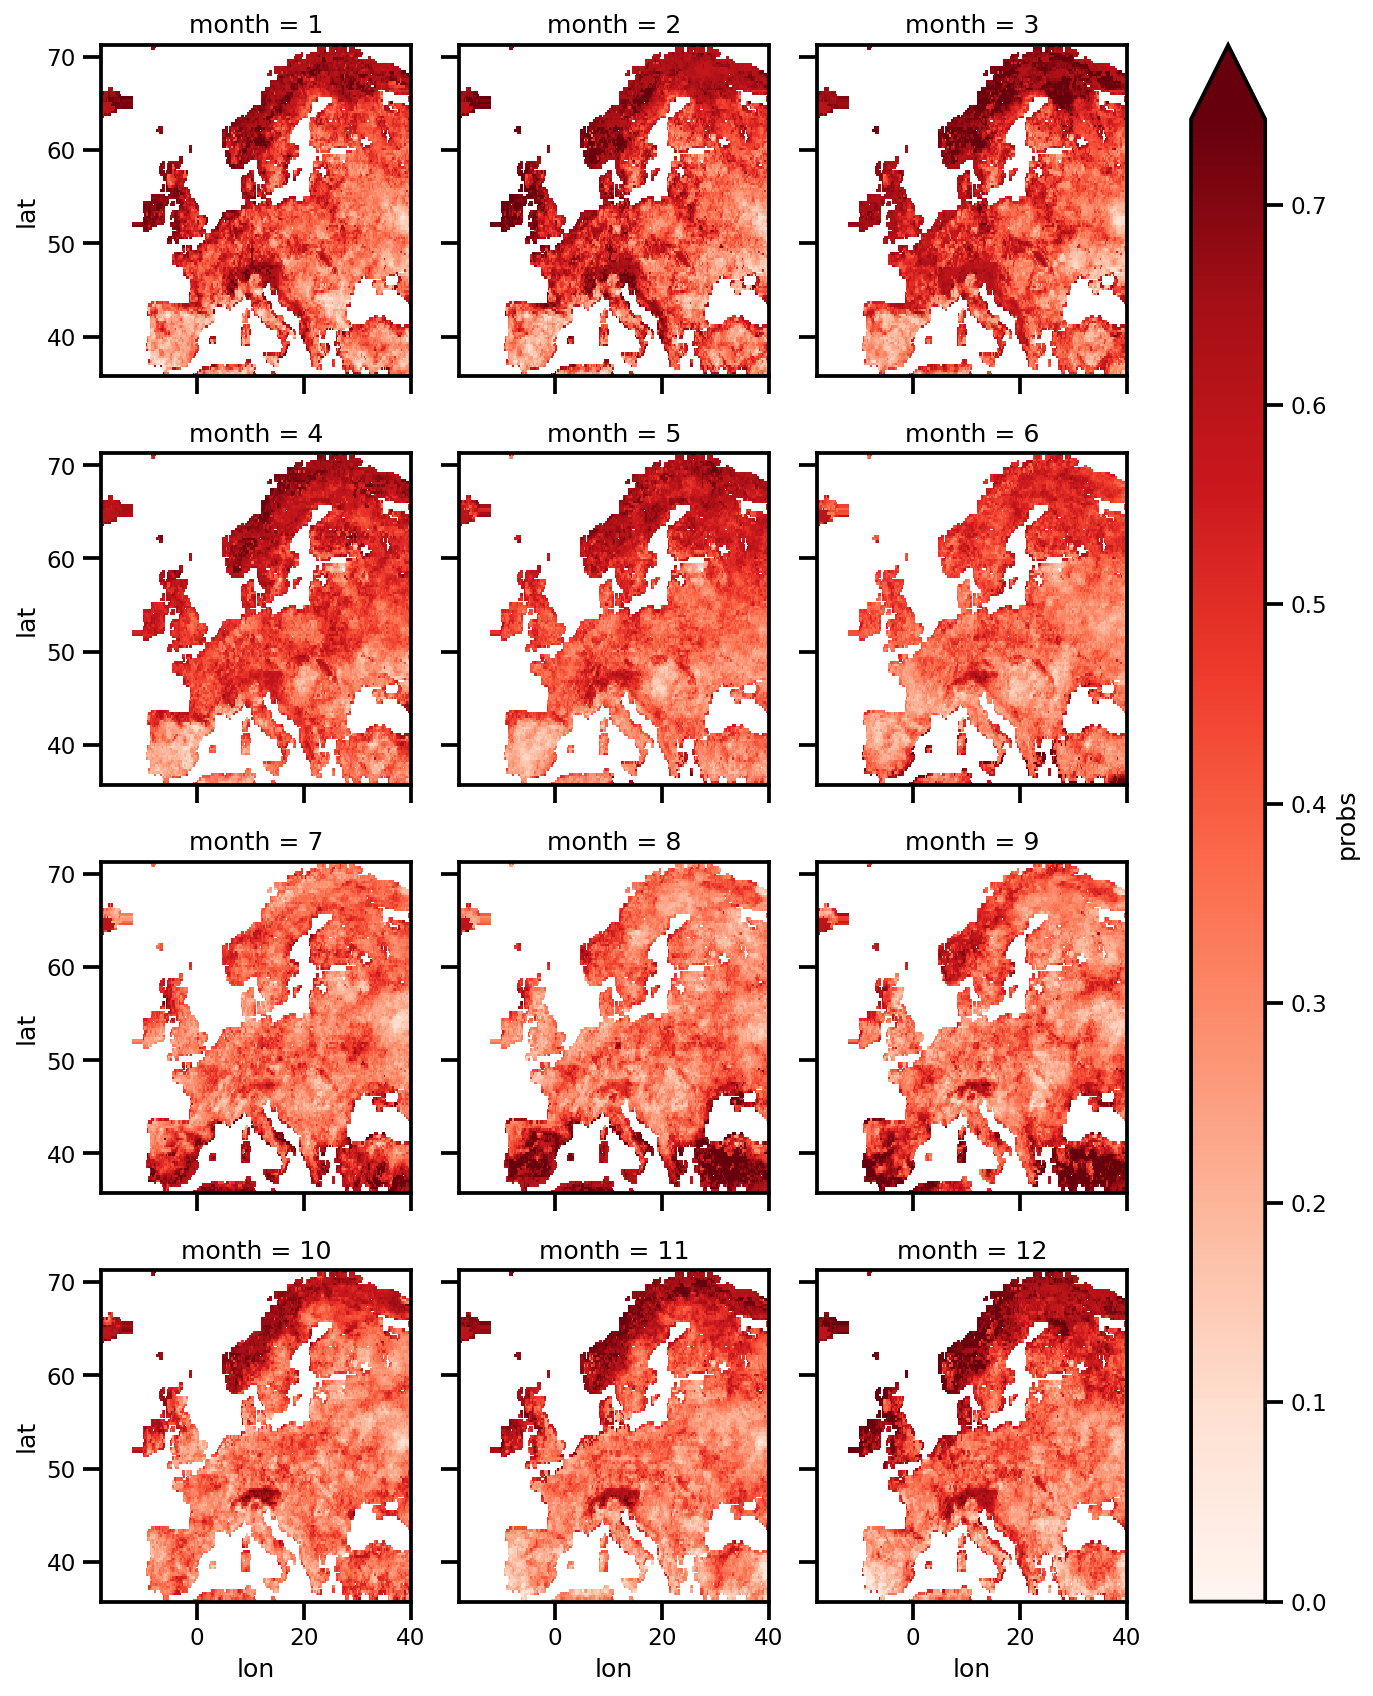

<Figure size 432x288 with 0 Axes>

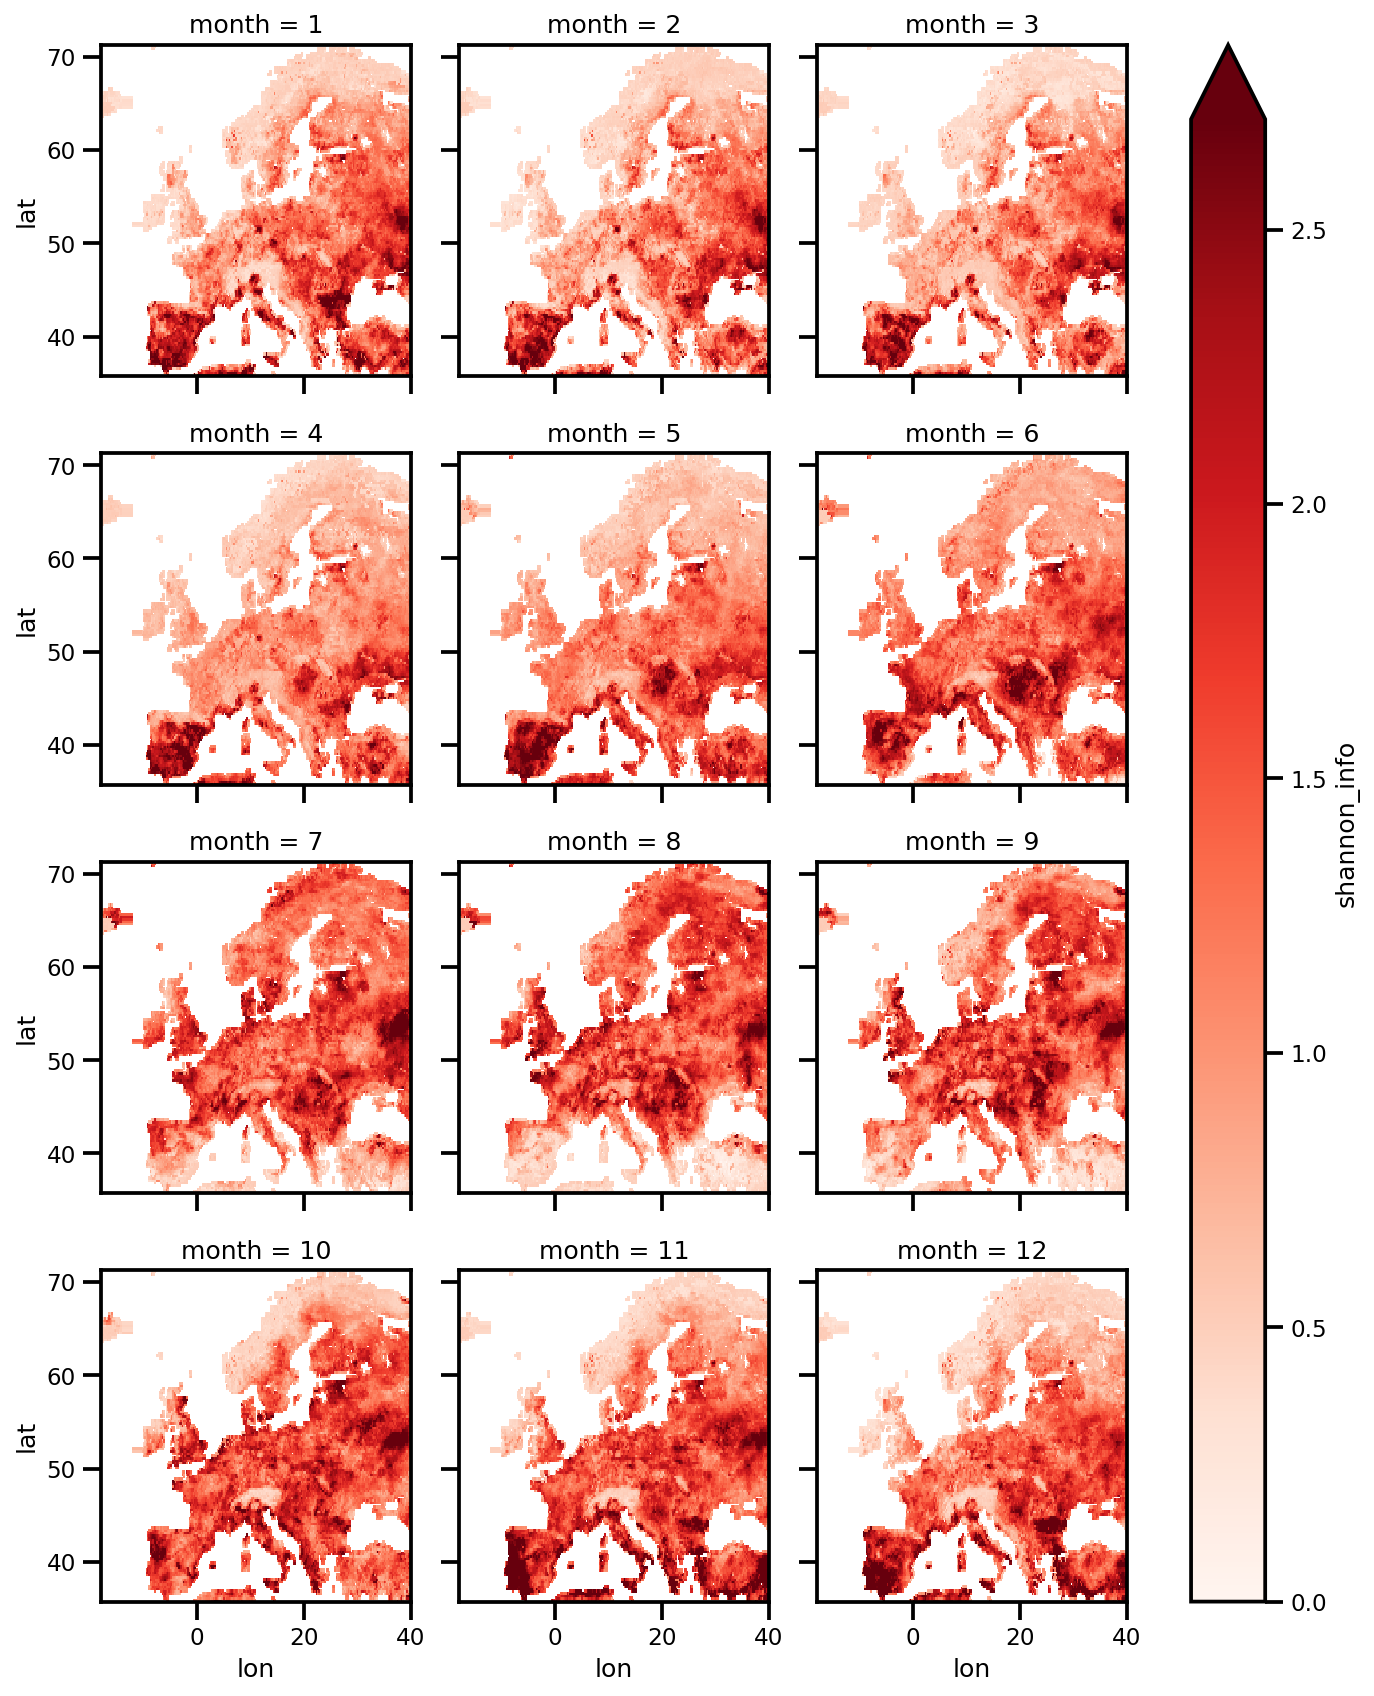

In [24]:
plot_monthly_map(probs_cubes, 'probs', None)
plot_monthly_map(probs_cubes, 'info', None)

### Figure 2.1 - Time Series (Probability)

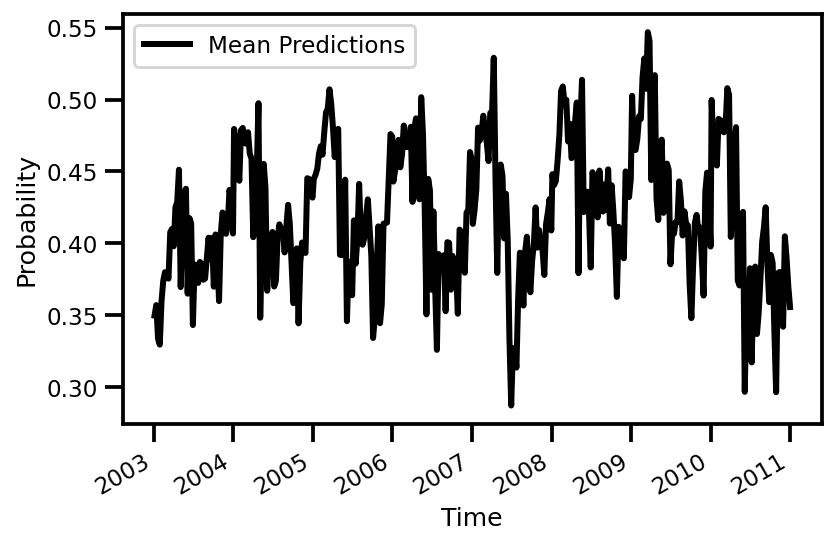

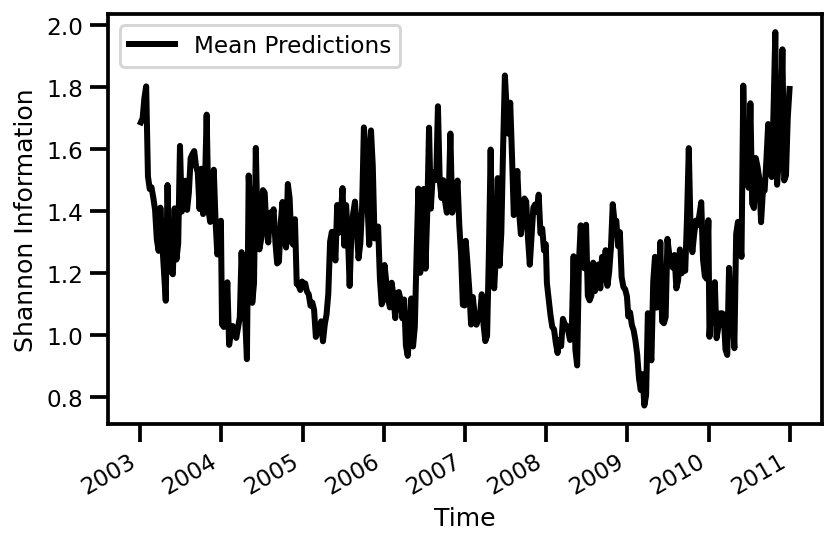

In [25]:
plot_ts(probs_cubes, 'probs', None)
plot_ts(probs_cubes, 'info', None)

### Figure 2.2 - Time Series w. Variance

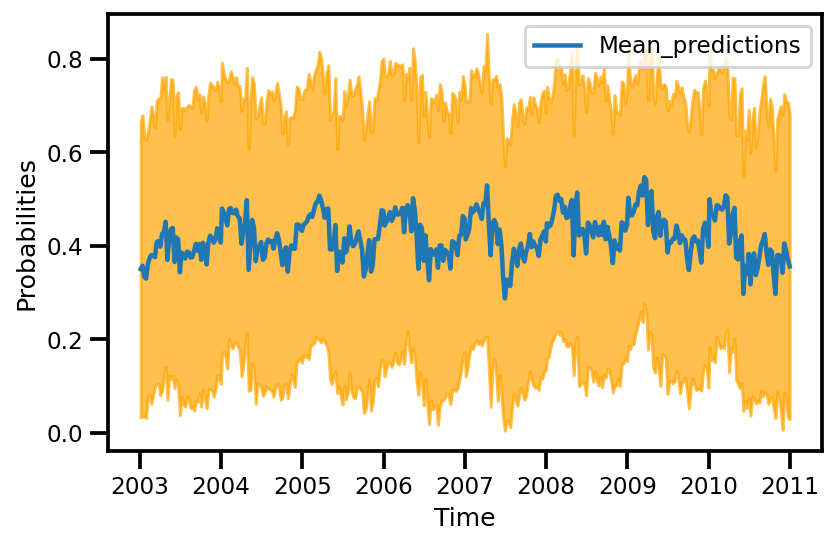

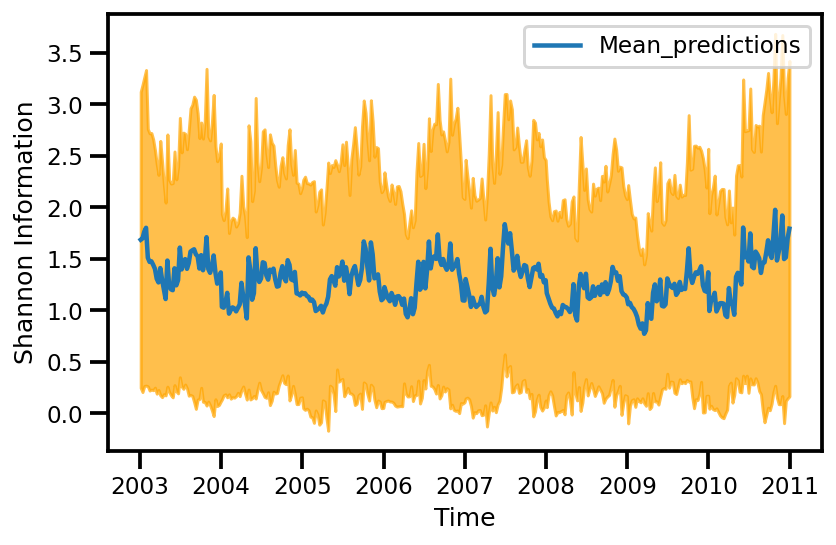

In [26]:
plot_ts_error(probs_cubes, 'probs', None); 
plot_ts_error(probs_cubes, 'info', None)

### Other Plots

### Information

$$
I(\mathbf{X}) = - \log p(\mathbf{X})
$$

In [245]:
probs_cubes['shannon_info'] = - np.log(probs_cubes.probs) #* np.log(2)

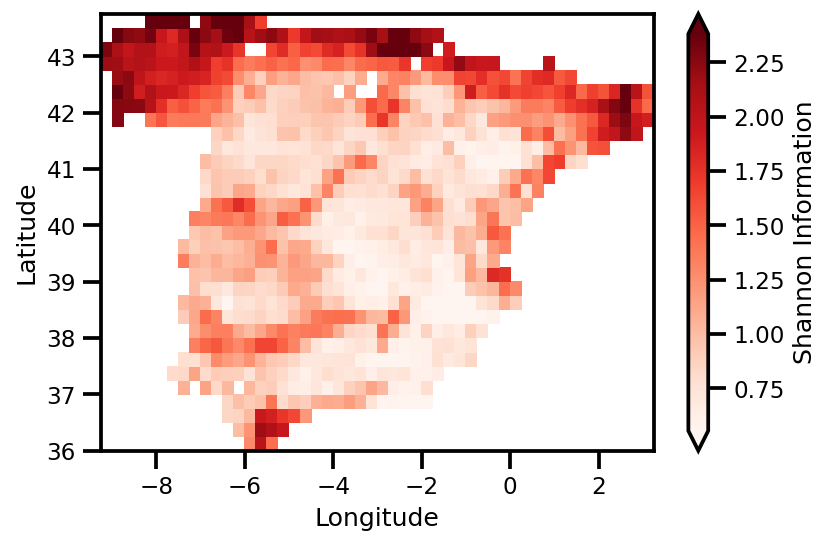

In [246]:
fig, ax = plt.subplots()
probs_cubes.shannon_info.mean(dim='time').plot(
    ax=ax,
    robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Shannon Information"}
)
ax.set(
    xlabel='Longitude',
    ylabel='Latitude',
)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

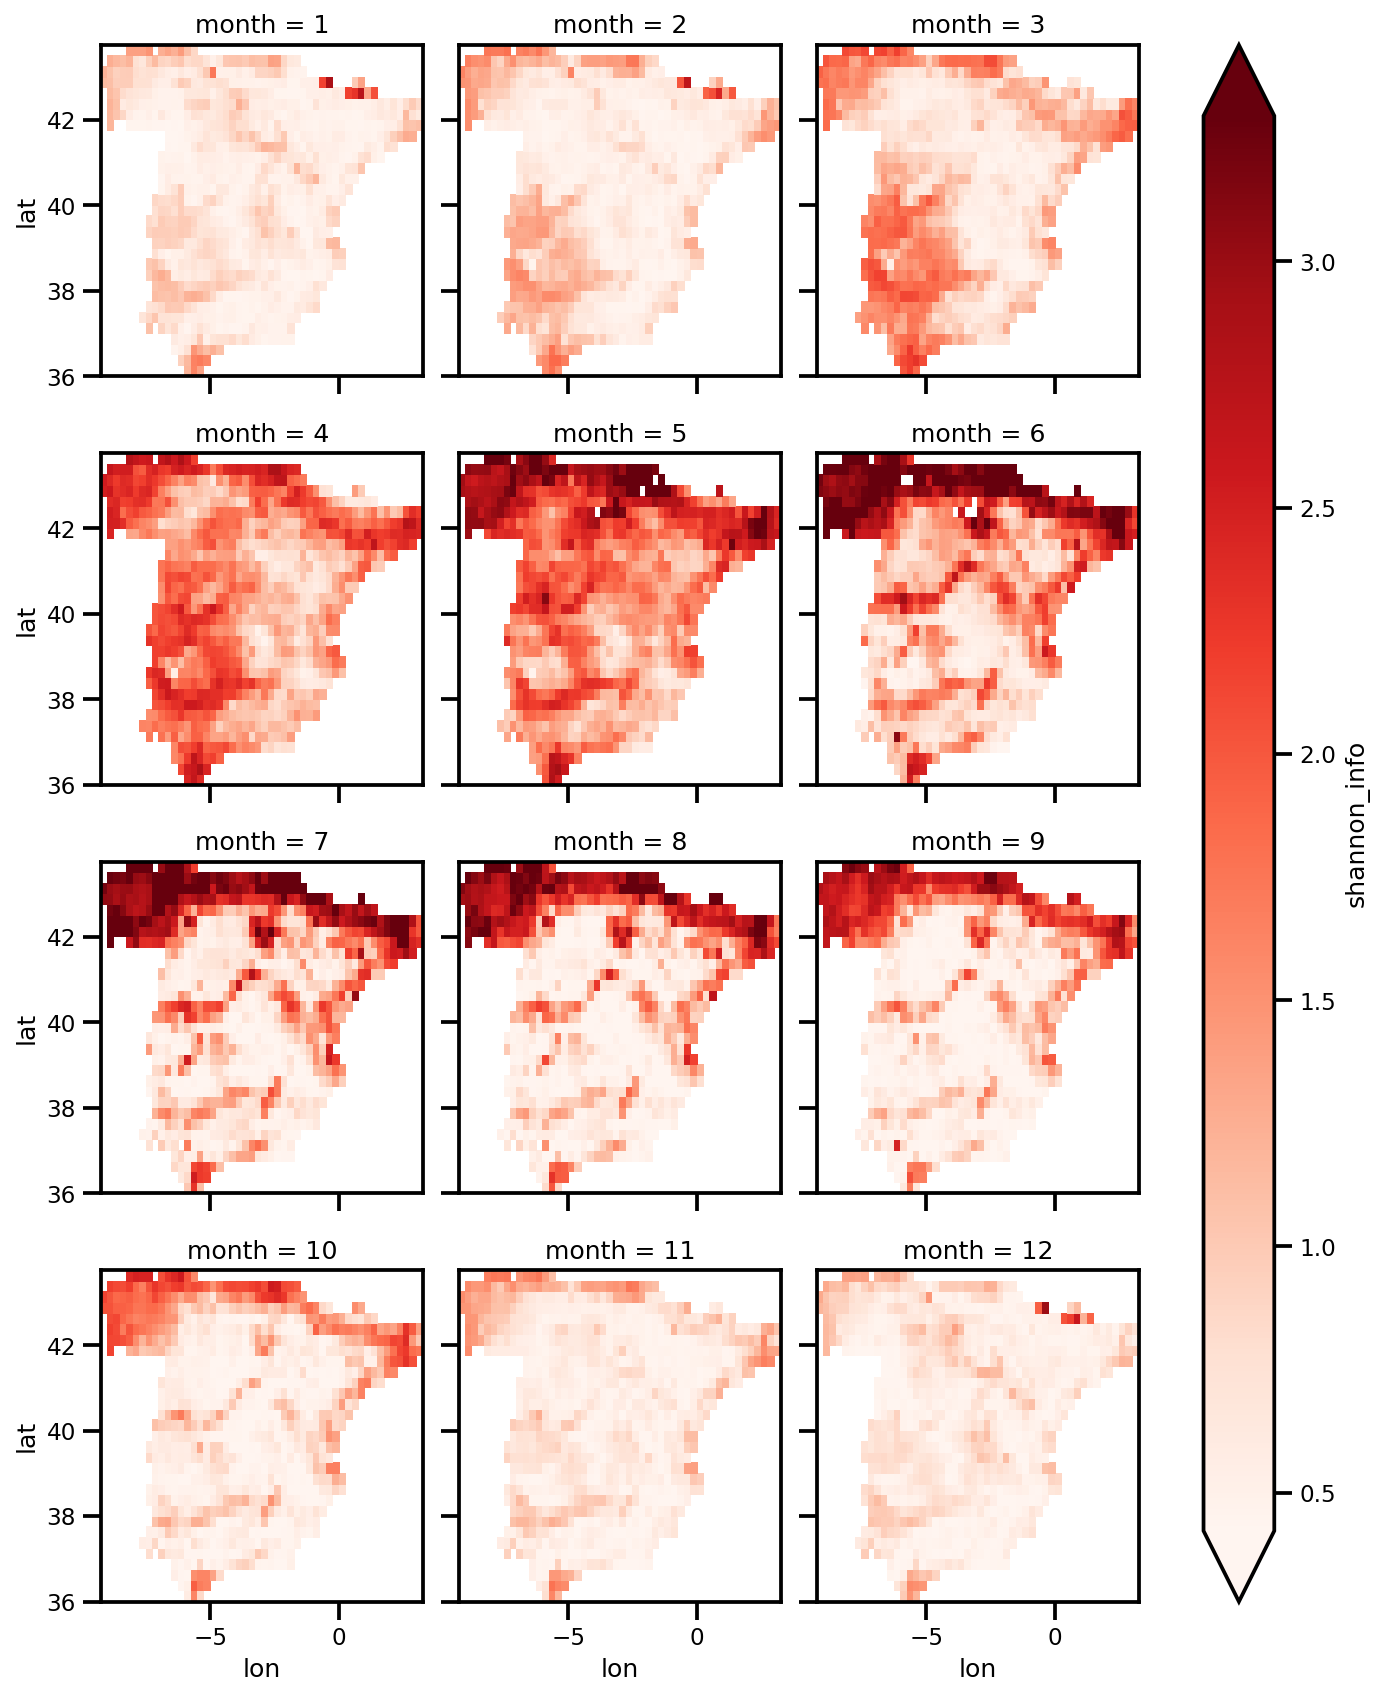

In [247]:
plt.figure(figsize=(10,10))
probs_cubes.shannon_info.groupby('time.month').mean().plot.pcolormesh(x='lon', y='lat', col='month', col_wrap=3, robust=True, cmap='Reds')

## Experiment II - Spain, 2010, Cube 2x2x2


In [248]:
!ls $RES_PATH/probs

gpp_spain_vgpp_r2010_v0.csv	  spain_vrm_r2010_v0.csv
rm_spain_vrm_r2002_2010_v0.csv	  spain_vrm_r2010_v0336.csv
rm_spain_vrm_r2010_v0.csv	  spain_vrm_r2010_v0_222.csv
spain_gpp_2002_2010_v0_222.csv	  spain_vsm_r2010_v0_222.csv
spain_vgpp_r2002_2010_v0_111.csv


In [249]:
probs_df.head()

probs
time       lat    lon             
2002-01-05 43.625 -8.125  0.241431
                  -7.875  0.258389
                  -7.625  0.239796
                  -7.375  0.164524
                  -6.875  0.339672

In [250]:
filename = "spain_gpp_2002_2010_v0_222.csv"

# read csv file
probs_df = pd.read_csv(str(RES_PATH.joinpath(f'probs/{filename}')))

# convert to datetime
probs_df['time'] = pd.to_datetime(probs_df['time'])


# create dataframe in the format for xarray
probs_df = probs_df.set_index(['time', 'lat', 'lon']).rename(columns={"0": 'probs'})

# remove probabilities greater than 1
probs_df['probs'][probs_df['probs'] >= 1.0] = np.nan

# create xarray cubes
probs_cubes = xr.Dataset.from_dataframe(probs_df, )
probs_cubes

<xarray.Dataset>
Dimensions:  (lat: 30, lon: 49, time: 413)
Coordinates:
  * time     (time) datetime64[ns] 2002-01-13 2002-01-21 ... 2010-12-31
  * lat      (lat) float64 36.12 36.38 36.62 36.88 ... 42.62 42.88 43.12 43.38
  * lon      (lon) float64 -8.875 -8.625 -8.375 -8.125 ... 2.625 2.875 3.125
Data variables:
    probs    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

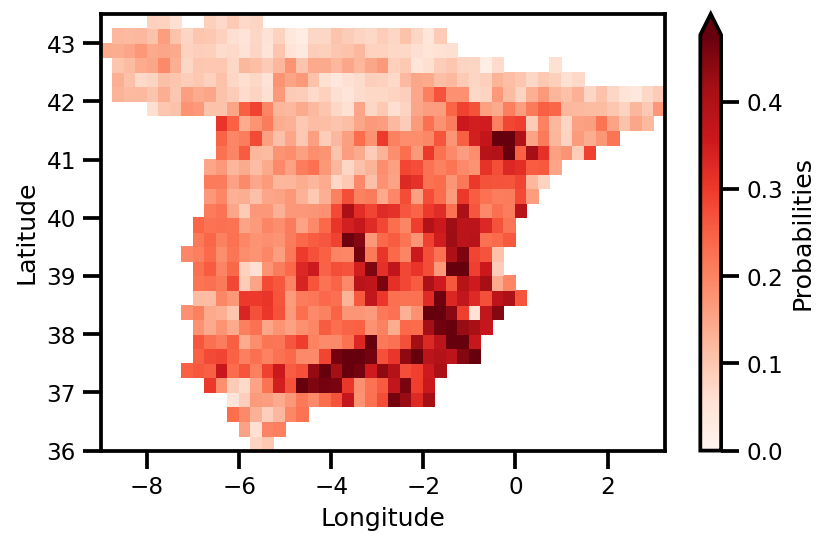

In [251]:
fig, ax = plt.subplots()
probs_cubes.probs.mean(dim='time').plot(
    ax=ax,
    vmin=0, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Probabilities"}
)
ax.set(
    xlabel='Longitude',
    ylabel='Latitude'
)
plt.tight_layout()

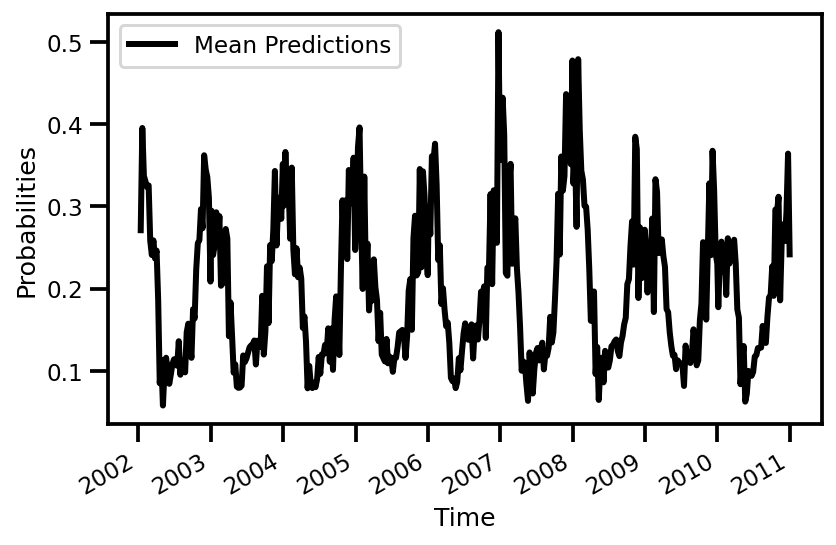

In [252]:
fig, ax = plt.subplots()
probs_cubes.probs.mean(dim=['lon', 'lat']).plot.line(ax=ax, color='black', linewidth=3)
ax.set(
    xlabel='Time',
    ylabel='Probabilities'
)
ax.legend(['Mean Predictions'])
plt.tight_layout()
plt.show()

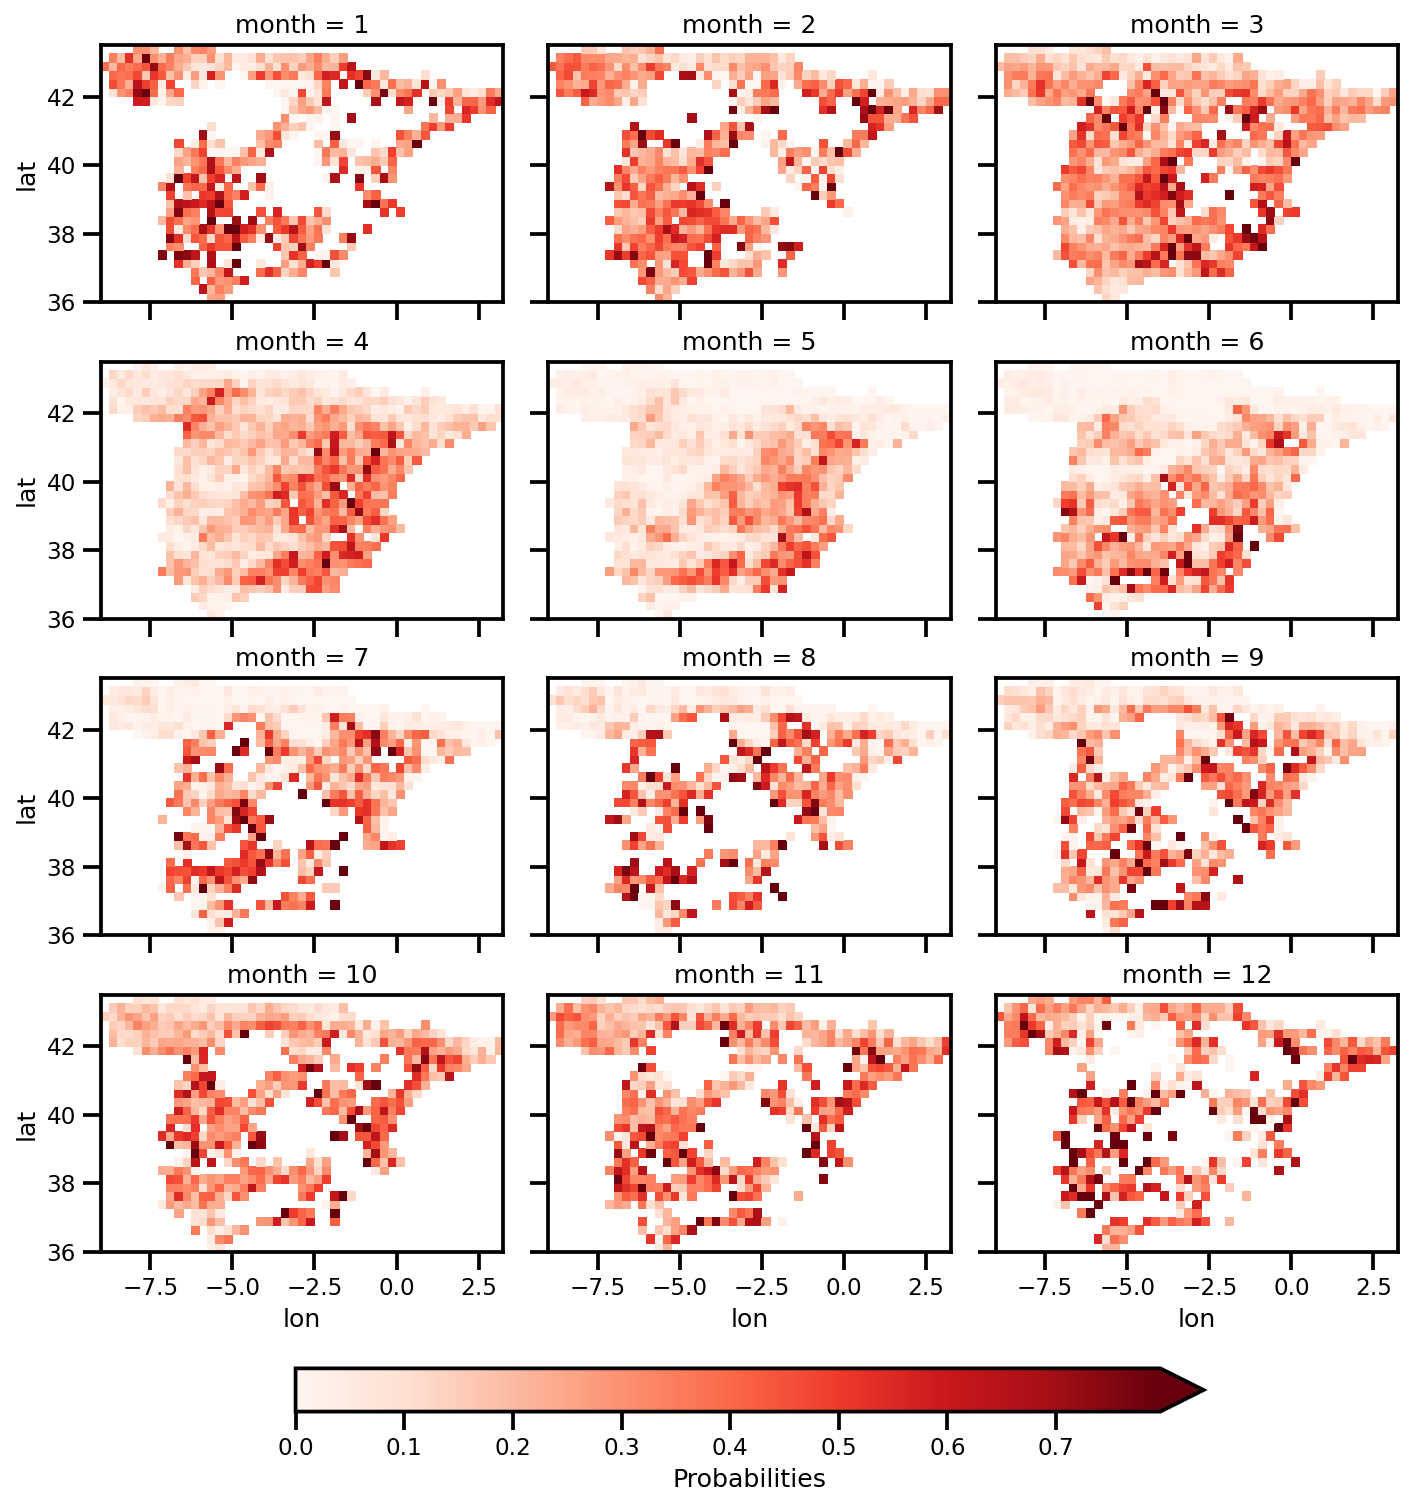

In [253]:
probs_cubes.probs.groupby('time.month').mean().plot.pcolormesh(
    x='lon', y='lat', 
    col='month', col_wrap=3, 
    vmin=0, robust=True, cmap='Reds',
    cbar_kwargs={
        'label': 'Probabilities', 
        'location':'bottom', 
        'shrink': 0.7, 
        'pad': 0.075
    }
)

### Anomalies

In [255]:
probs_cubes['shannon_info'] = - np.log(probs_cubes.probs) #* np.log(2)

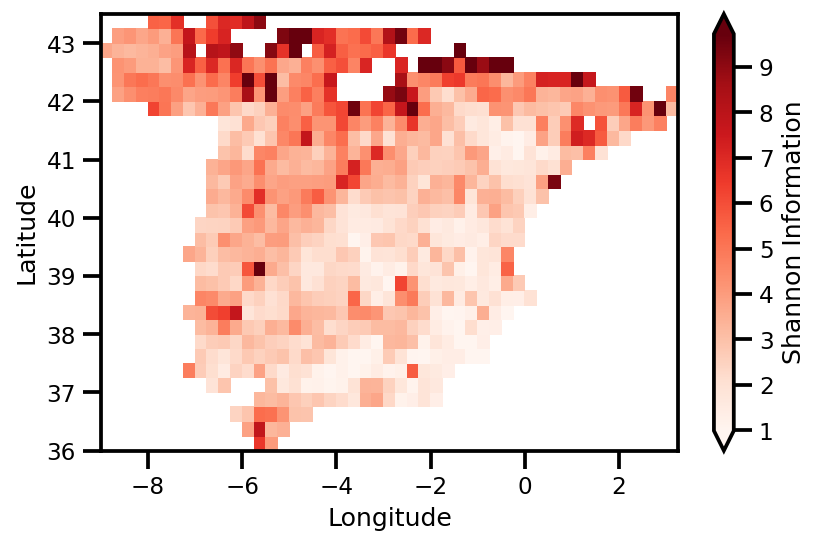

In [256]:
fig, ax = plt.subplots()
probs_cubes.shannon_info.mean(dim='time').plot(
    ax=ax,
    robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Shannon Information"}
)
ax.set(
    xlabel='Longitude',
    ylabel='Latitude',
)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

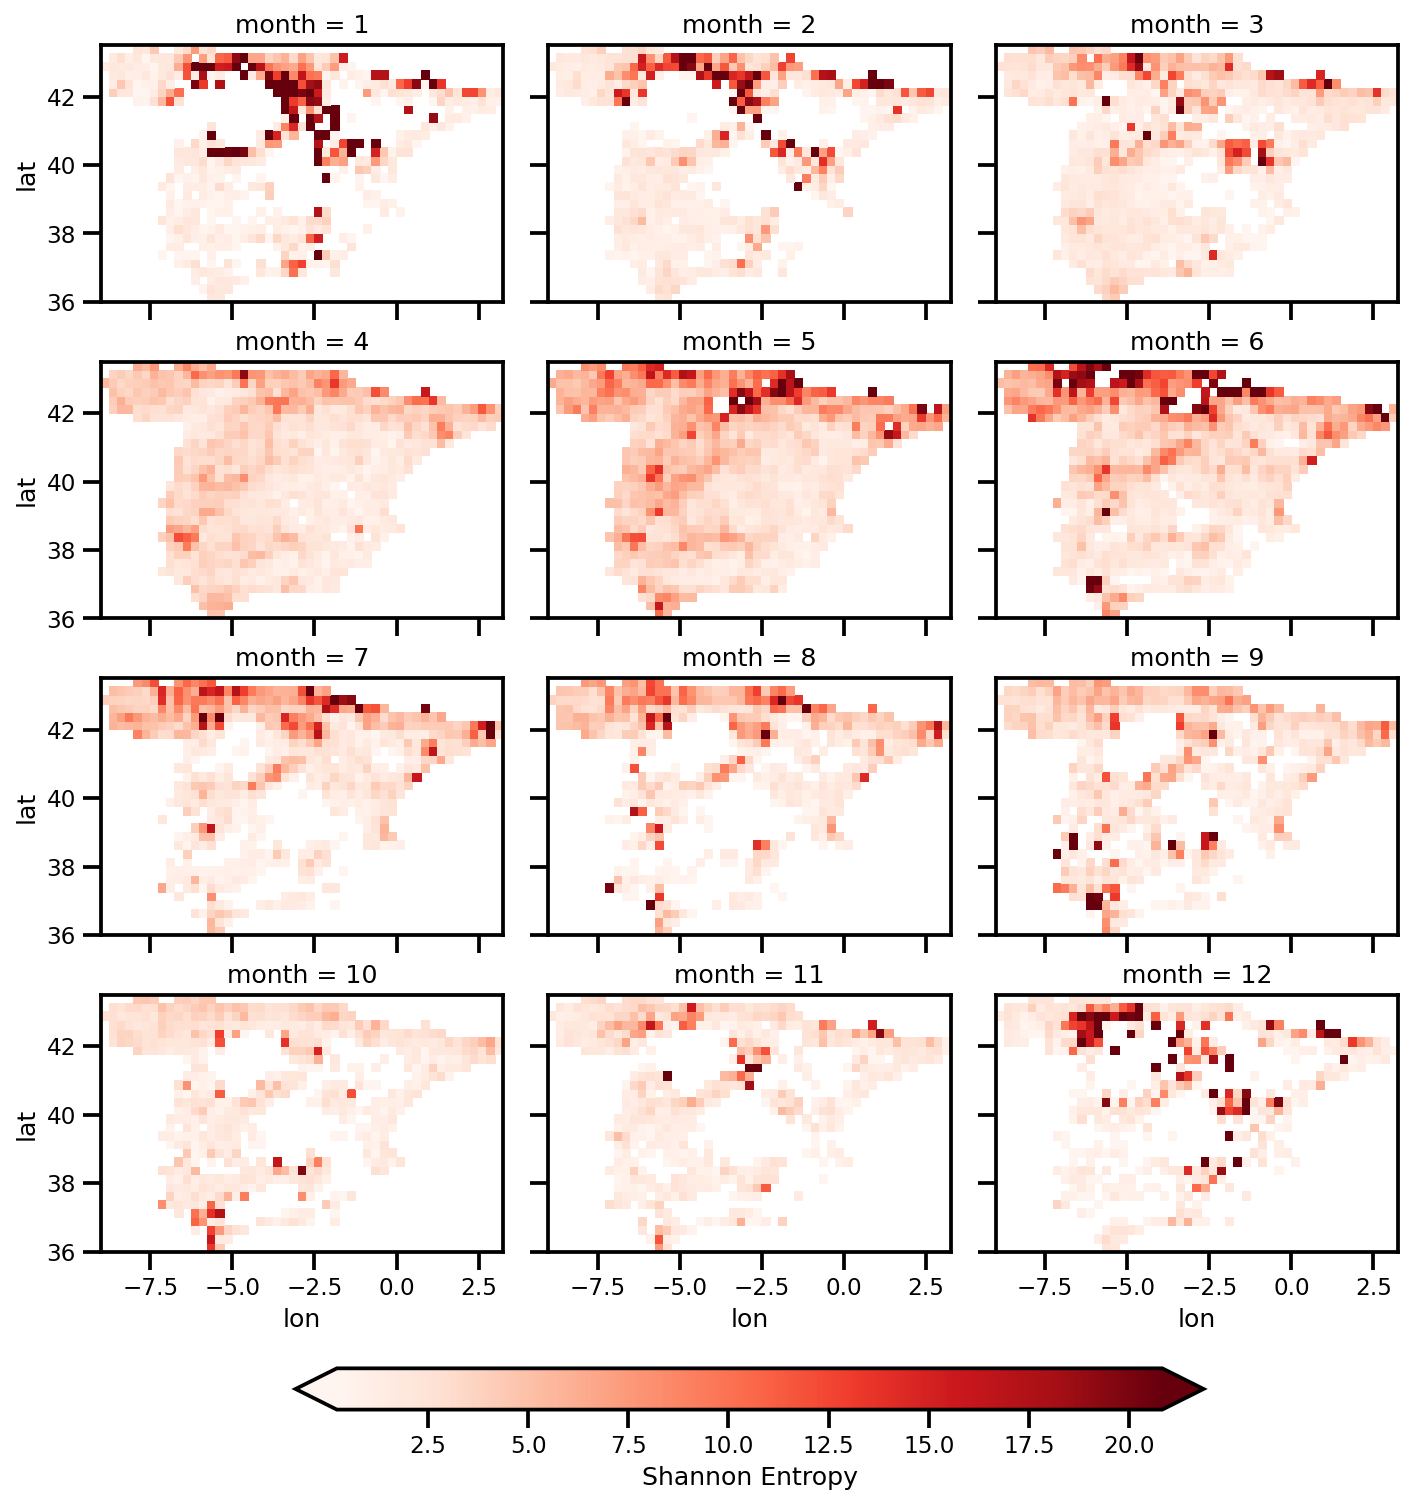

In [257]:
plt.figure(figsize=(10,10))
probs_cubes.shannon_info.groupby('time.month').mean().plot.pcolormesh(
    x='lon', y='lat', 
    col='month', col_wrap=3, 
    robust=True, cmap='Reds',
    cbar_kwargs={
        'label': 'Shannon Entropy', 
        'location':'bottom', 
        'shrink': 0.7, 
        'pad': 0.075
    }
)

In [ ]:
# define threshold
instances = 4

# calculate densities

# calculate density threshold


## Experiment Steps